## Necessary Imports

In [1]:
!pip install pmdarima fancyimpute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 37.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 11.8 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29880 sha256=7f6e821f2e112e1543b531f54d0a23a3a8a414c3a9a5dd5d386022b0d9e9a37e
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11335 sha256=0cce223dd741ba608bc87e5c7109f87f5930246f3ca8753b27d14976fe4df3f1
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [2]:
#import all necessary libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from random import gauss
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from random import random
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
#arima models
from pmdarima.arima import auto_arima
from pmdarima import pipeline
from pmdarima import model_selection
from pmdarima import preprocessing as ppc
from pmdarima import arima
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

#metrics RMSE, MSE, R2
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,r2_score

## Metrics

In [3]:
def mda(actual, predicted):
    """
    Calculates the Mean Directional Accuracy (MDA) for two time series.
    
    Parameters:
    actual (array-like): The actual values for the time series.
    predicted (array-like): The predicted values for the time series.
    
    Returns:
    float: The MDA value.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # calculate the signs of the differences between consecutive values
    actual_diff = np.diff(actual)
    actual_signs = np.sign(actual_diff)
    predicted_diff = np.diff(predicted)
    predicted_signs = np.sign(predicted_diff)
    
    # count the number of times the signs are the same
    num_correct = np.sum(actual_signs == predicted_signs)
    
    # calculate the MDA value
    mda = num_correct / (len(actual) - 1)
    
    return mda

In [4]:
def metrics(y_true,y_pred):
  print("Da:",mda(y_true,y_pred))
  print("~"*50)
  print("rmse:",np.sqrt(mean_squared_error(y_true,y_pred)))
  print("~"*50)
  print("mae:",mean_absolute_error(y_true,y_pred))
  print("~"*50)
  print("mape:",mean_absolute_percentage_error(y_true,y_pred))
  print("~"*50)
  print("R2:",r2_score(y_true,y_pred))

In [5]:
class CFG:
    img_dim1 = 20
    img_dim2 = 10
        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)}) 

## Data preparation

In [87]:
#read the data
df=pd.read_excel("/content/Random Price Dataset Trial Assignment.xlsx")

In [7]:
len(df.columns)
#create Dataframe for all predictions
overall_predictions=pd.DataFrame()

In [8]:
#conversion of datetime required for time series data
df["Date"]=pd.to_datetime(df["Date"])

# Univariate Analysis

In [10]:
df_univariate=df[["Date","Domestic Market (Contract) Blow Molding, Low"]]

In [11]:
df_univariate["Date"]=pd.to_datetime(df_univariate["Date"])

<ipython-input-11-b6f2414498b1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_univariate["Date"]=pd.to_datetime(df_univariate["Date"])


In [12]:
df["Date"].min(),df["Date"].max()

(Timestamp('2000-01-01 00:00:00'), Timestamp('2022-12-01 00:00:00'))

In [13]:
df_univariate["Domestic Market (Contract) Blow Molding, Low"]=df_univariate["Domestic Market (Contract) Blow Molding, Low"].astype(float)

<ipython-input-13-9a9cb244d52d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_univariate["Domestic Market (Contract) Blow Molding, Low"]=df_univariate["Domestic Market (Contract) Blow Molding, Low"].astype(float)


In [14]:
df_univariate.set_index('Date', inplace = True)


<Axes: xlabel='Date'>

<Figure size 1000x500 with 0 Axes>

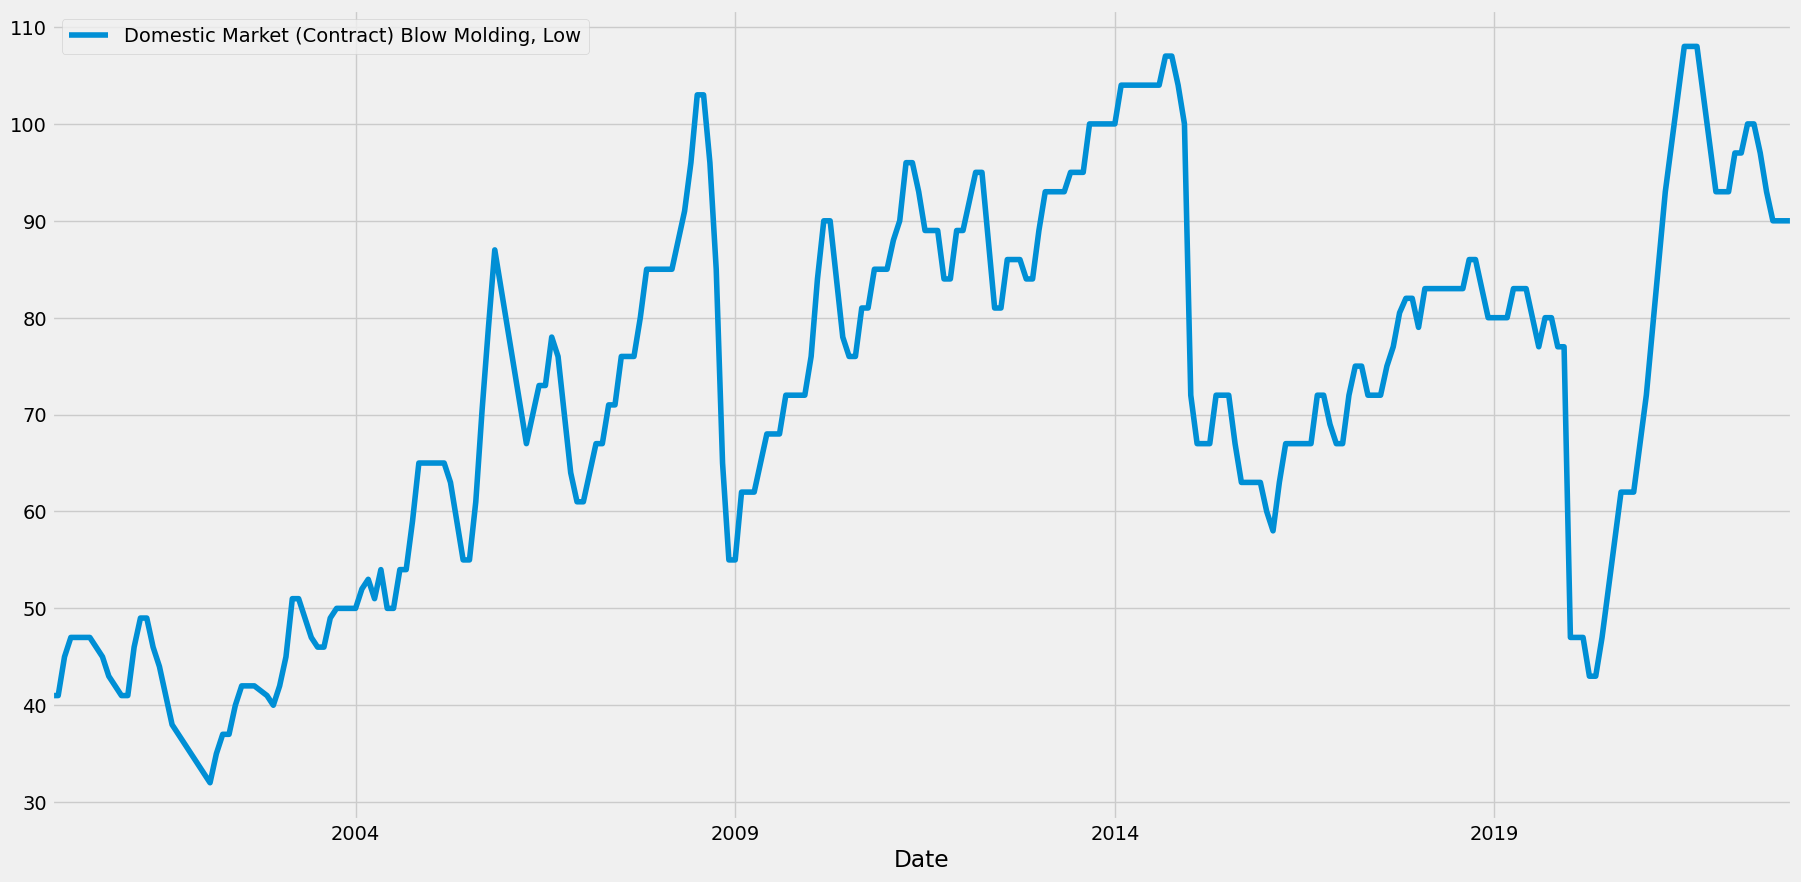

In [15]:
plt.figure(figsize=(10,5))
df_univariate.plot()


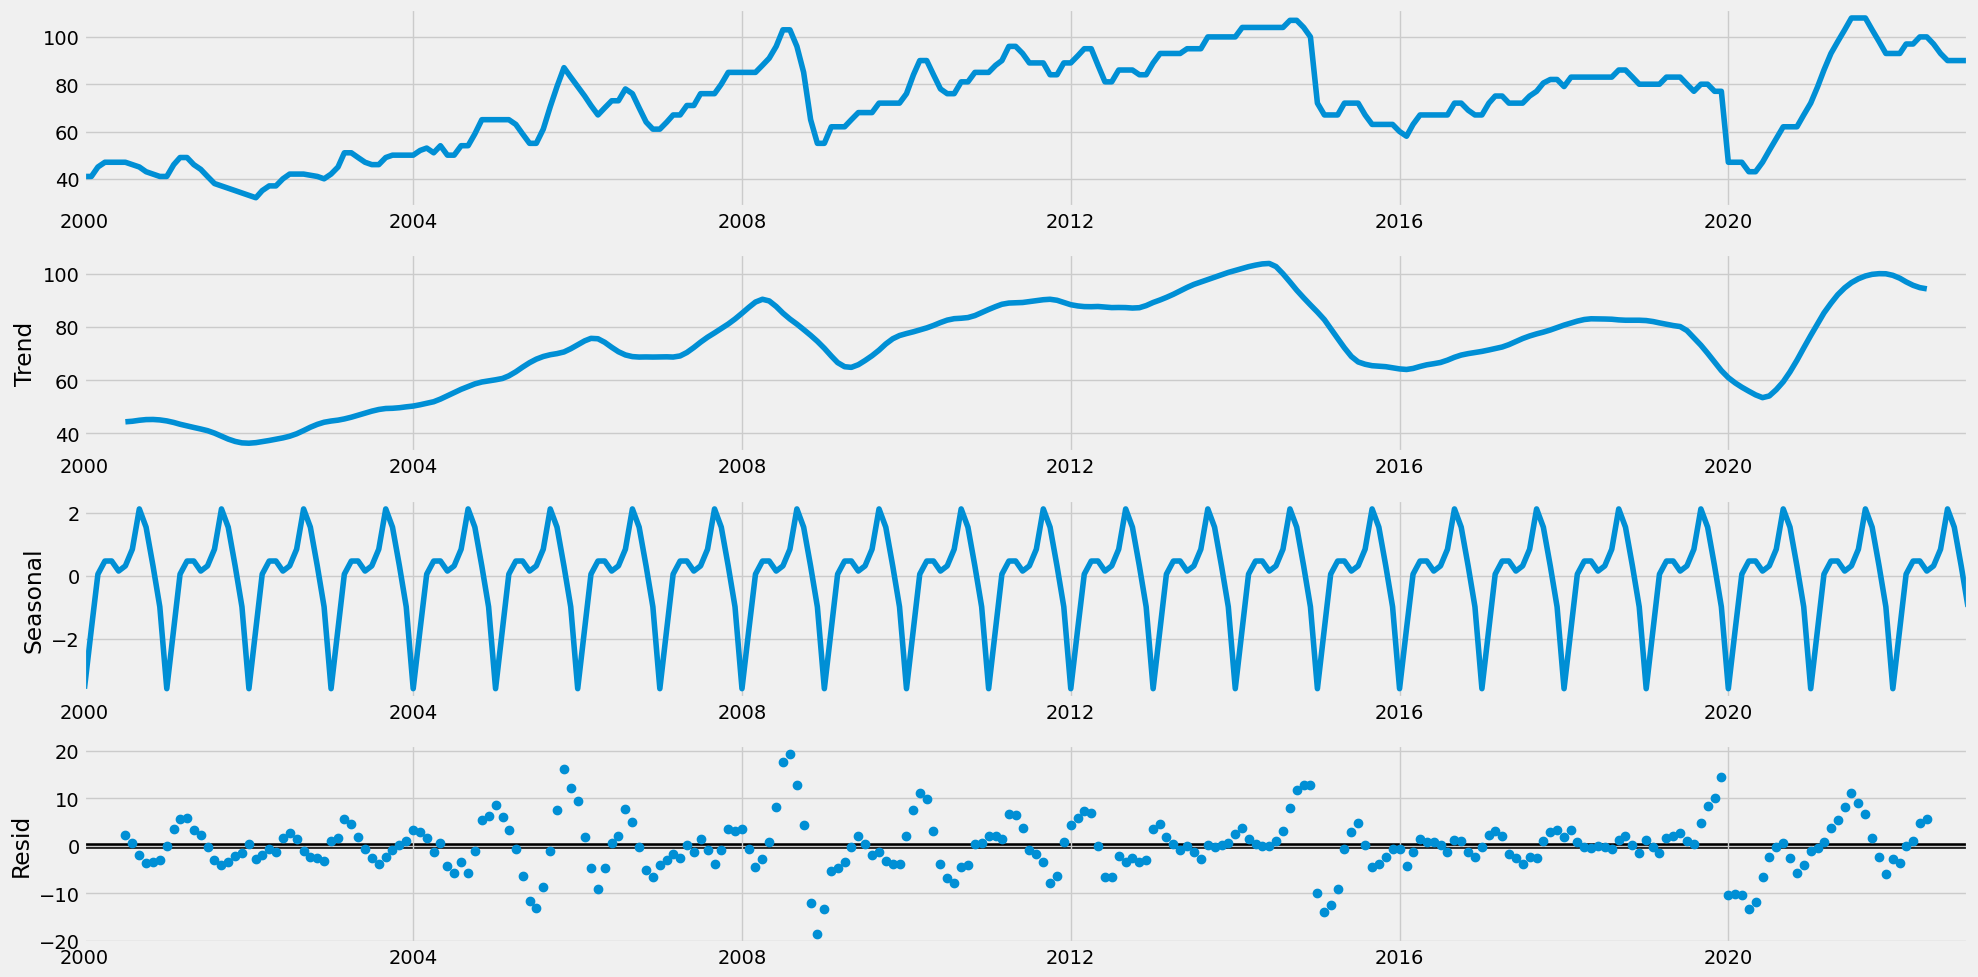

In [16]:
decomposition = sm.tsa.seasonal_decompose(df_univariate,period =12) 
figure = decomposition.plot()
plt.show()

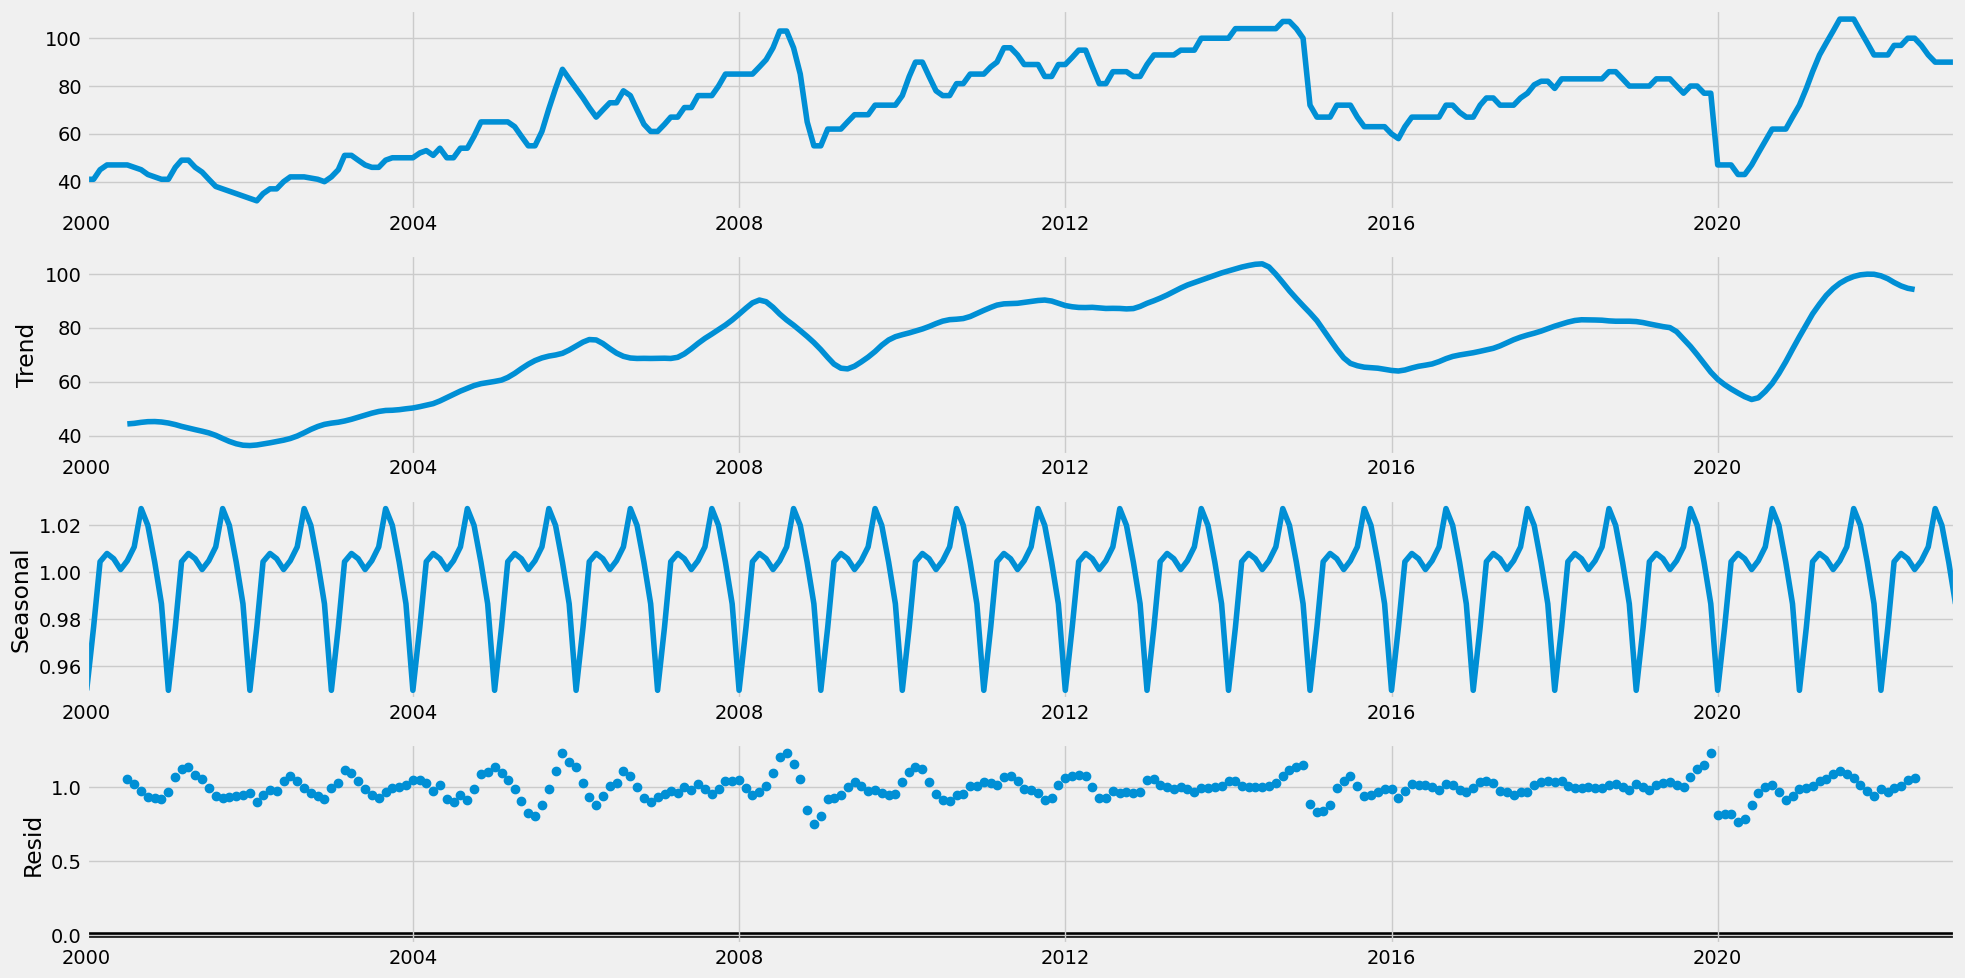

In [17]:
decomposition = sm.tsa.seasonal_decompose(df_univariate,period =12, model = 'multiplicative')
figure = decomposition.plot()
plt.show()

In [18]:
df_univariate.dtypes

Domestic Market (Contract) Blow Molding, Low    float64
dtype: object

In [19]:
cutoff_date = '2018-04-01'
xtrain, xvalid  = df_univariate.loc[df_univariate.index <= cutoff_date], df_univariate.loc[df_univariate.index > cutoff_date]
print(xtrain.shape, xvalid.shape)

(220, 1) (56, 1)


## **Exponential smoothing model**

- Exponential smoothing with trend (ETS) extends simple exponential smoothing to include a trend component. It is suitable for time series data with a linear or additive trend. The ETS method uses two equations: one for updating the level (S_t) and another for updating the trend (T_t) at each time period:

- Level equation: S_t = α * Y_t + (1 - α) * (S_{t-1} + T_{t-1})
- Trend equation: T_t = β * (S_t - S_{t-1}) + (1 - β) * T_{t-1}

where:

- α is the level smoothing parameter, as in simple exponential smoothing.
- β is the trend smoothing parameter (0 < β < 1) that determines the weight given to the change in level between consecutive periods. A smaller β gives more weight to past changes, while a larger β puts more emphasis on recent changes.
Similarly, an initial level value, S_0, and an initial trend value, T_0, need to be specified to start the smoothing process.

- Exponential smoothing methods are easy to implement and provide reasonably accurate forecasts, especially when the time series has a stable pattern.

In [22]:
#exponential smoothing model with default alpha values
fit1 = ExponentialSmoothing(xtrain.values, seasonal_periods=12, trend='mul', seasonal='mul')
fit1 = fit1.fit()

In [23]:
fit1.params_formatted

,name,param,optimized
smoothing_level,alpha,1.000000e+00,True
smoothing_trend,beta,7.899557e-01,True
smoothing_seasonal,gamma,3.240741e-09,True
initial_level,l.0,2.953893e+01,True
initial_trend,b.0,9.981319e-01,True
initial_seasons.0,s.0,1.390666e+00,True
initial_seasons.1,s.1,1.420811e+00,True
initial_seasons.2,s.2,1.439610e+00,True
initial_seasons.3,s.3,1.440685e+00,True
initial_seasons.4,s.4,1.427955e+00,True


In [24]:
prediction = fit1.forecast(len(xvalid)).copy()
prediction


array([82.11916125, 81.11218613, 81.30603477, 82.17085   , 83.60339292,
       83.39751115, 82.82181203, 81.29523452, 78.83541482, 80.40000148,
       81.3178226 , 81.23269878, 80.37061555, 79.38508173, 79.57480279,
       80.4212037 , 81.82324379, 81.62174581, 81.05830494, 79.56423252,
       77.15678923, 78.68806148, 79.58633963, 79.50302833, 78.65930125,
       77.6947522 , 77.88043357, 78.70881224, 80.080999  , 79.88379147,
       79.33234782, 77.87008836, 75.51390625, 77.01257345, 77.89172475,
       77.81018739, 76.98442561, 76.04041449, 76.22214219, 77.03288237,
       78.37585144, 78.18284301, 77.64314114, 76.21201726, 73.90600482,
       75.37276122, 76.23319295, 76.15339174, 75.34521273, 74.42130224,
       74.59916045, 75.39263771, 76.70701123, 76.51811249, 75.98990237,
       74.5892511 ])

In [25]:
x_val=xvalid.values.reshape(-1,)

<ipython-input-28-e98cdcab3420>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xvalid['prediction'] = prediction


<Axes: xlabel='Date'>

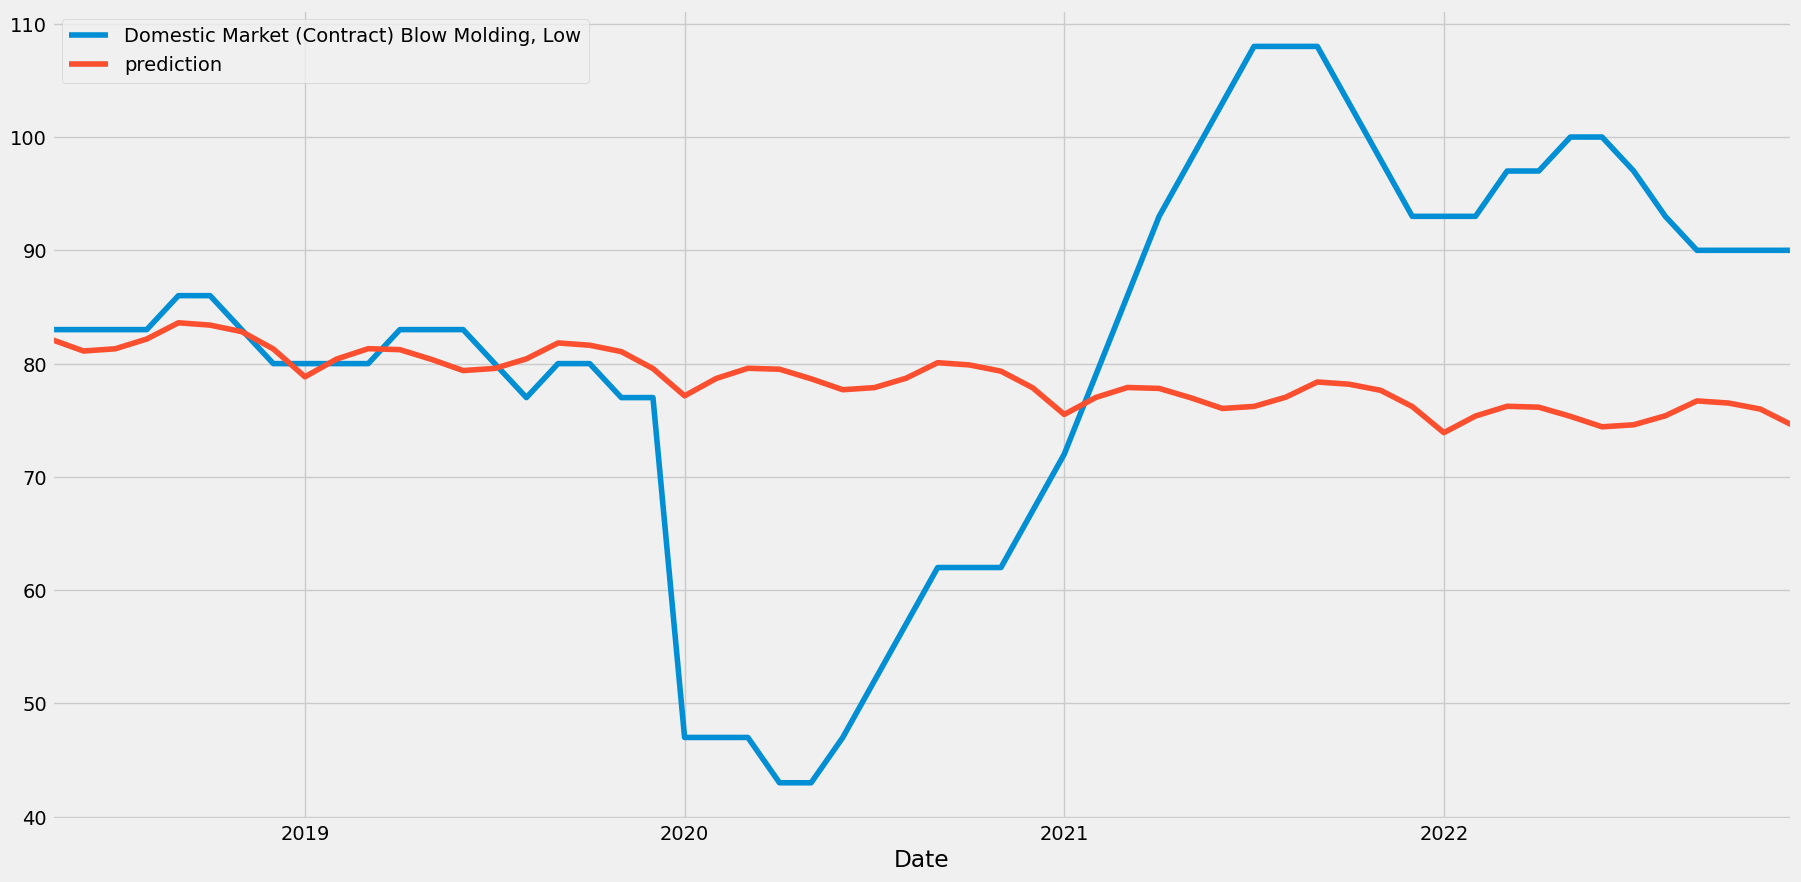

In [28]:
xvalid['prediction'] = prediction
xvalid.plot()

In [29]:
metrics(x_val,prediction)

Da: 0.3090909090909091
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
rmse: 18.35391199192477
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
mae: 14.312405966157439
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
mape: 0.2027774282460009
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
R2: -0.1281680441152626


In [30]:
overall_predictions["ytrue"]=x_val
overall_predictions["exp_pred"]=prediction

## ADF-test


- The Augmented Dickey-Fuller (ADF) test is a statistical test commonly used in time series analysis to determine whether a given time series is stationary or not. Stationarity refers to the property of a time series where its statistical properties (such as mean and variance) remain constant over time.

- The ADF test is based on the autoregressive model and tests the null hypothesis that a unit root is present in the time series, indicating non-stationarity. 

In [31]:
result = adfuller(df_univariate.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.238045
p-value: 0.192728


**hypothesis(H0)**: The time series is not stationary because there is a unit root (if p-value > 0.05)

## **ARIMA MODEL** 

In [32]:
df_univariate["Domestic Market (Contract) Blow Molding, Low"]

Date
2000-01-01    41.0
2000-02-01    41.0
2000-03-01    45.0
2000-04-01    47.0
2000-05-01    47.0
              ... 
2022-08-01    93.0
2022-09-01    90.0
2022-10-01    90.0
2022-11-01    90.0
2022-12-01    90.0
Name: Domestic Market (Contract) Blow Molding, Low, Length: 276, dtype: float64

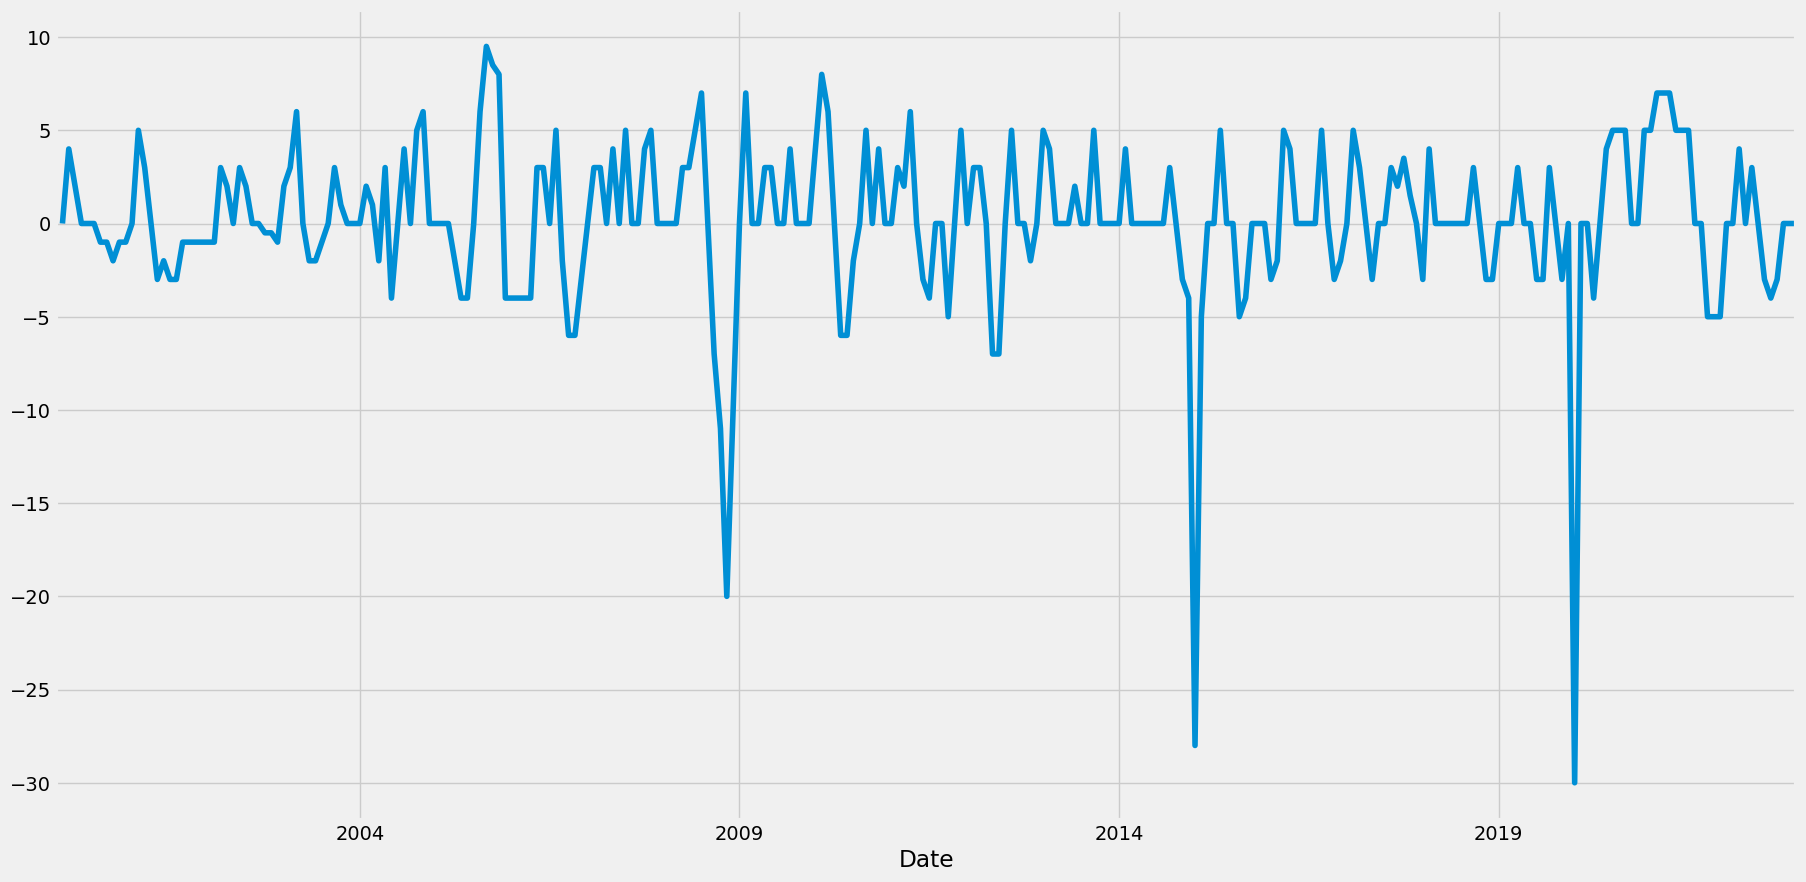

In [ ]:
ydat = df_univariate["Domestic Market (Contract) Blow Molding, Low"].diff()
ydat.plot()
print()

- As you can see, differencing the time series once removes a linear trend and produces a series for which the null is not rejected in Dickey-Fuller test - this is despite the fact the volatility clearly goes up in the latter part of the sample!

- The basic idea is that if we are dealing with a series that can be represented as a stationary process with polynomial trend, we can model it jointly (instead of manually differencing  d
  times and then flipping back).


In [ ]:
# construct a pipeline, combining feature preprocessing and the model to fit
pipe = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=4)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                              seasonal=False,  # because we use Fourier
                              suppress_warnings=True))
])



In [ ]:
pipe.fit(xtrain)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=nan sec


ValueError: ignored

- Your input data may not be suitable for ARIMA modeling. For instance, it could be a simple polynomial or solved by linear regression (i.e., differencing the time series has made it perfectly constant).


## Fb prophet model

In [83]:
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 6.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for o

In [88]:
prop=df[["Date","Domestic Market (Contract) Blow Molding, Low"]]

In [89]:
prop.columns = ['ds', 'y']

In [90]:
cutoff_date = '2018-04-01'
xtrain, xvalid  = prop.loc[prop["ds"] <= cutoff_date], prop.loc[prop["ds"] > cutoff_date]
print(xtrain.shape, xvalid.shape)

(220, 2) (56, 2)


In [91]:
from prophet import Prophet
model = Prophet()
# fit the model
model.fit(prop)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpokz2j5qf/sakzptff.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpokz2j5qf/fg9y6_6h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81357', 'data', 'file=/tmp/tmpokz2j5qf/sakzptff.json', 'init=/tmp/tmpokz2j5qf/fg9y6_6h.json', 'output', 'file=/tmp/tmpokz2j5qf/prophet_modelm4nrwhhx/prophet_model-20230529141152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:11:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:11:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [92]:
future2 = model.make_future_dataframe(periods=0,freq="m")
prophet_forecast = model.predict(future2)

In [93]:
prop_f=prophet_forecast[prophet_forecast["ds"]>"2018-04-01"]["yhat"]
prop_f.values

array([82.69174823, 82.34761196, 82.37824598, 82.58267123, 83.70199962,
       83.29644734, 82.34524769, 81.31114529, 78.00858827, 79.43322452,
       82.40146642, 82.50414702, 82.51349456, 82.07170144, 81.85936217,
       81.87377326, 83.1082516 , 82.97704949, 82.3908093 , 81.54408701,
       77.27195109, 78.10043089, 80.68933906, 81.5143487 , 81.5423095 ,
       81.37980501, 81.89608309, 82.5038426 , 83.42081082, 82.4813542 ,
       80.78251067, 79.3021917 , 77.9186215 , 80.62114666, 80.74490147,
       81.34432265, 81.37202176, 81.12104758, 81.39469553, 81.79699098,
       82.81043522, 82.13529384, 80.81304208, 79.567731  , 77.22843725,
       79.27797857, 80.81780586, 81.17646419, 81.19793217, 80.8537959 ,
       80.88442992, 81.08885516, 82.20818356, 81.80263128, 80.85143163,
       79.81732923])

In [94]:
metrics(xvalid["y"],prop_f.values)

Da: 0.38181818181818183
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
rmse: 17.165920919779463
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
mae: 13.012675095269362
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
mape: 0.19362671382210203
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
R2: 0.013150968765727966


In [95]:
overall_predictions["pro_pred"]=prop_f.values

## Sarima model

- SARIMA, which stands for Seasonal Autoregressive Integrated Moving Average, is a popular and powerful model used for time series forecasting. It is an extension of the ARIMA model that incorporates seasonality in the data.

- The SARIMA model is suitable for time series data that exhibit both trend and seasonality. It combines three components: autoregressive (AR), differencing (I), and moving average (MA), along with a seasonal component (S). 

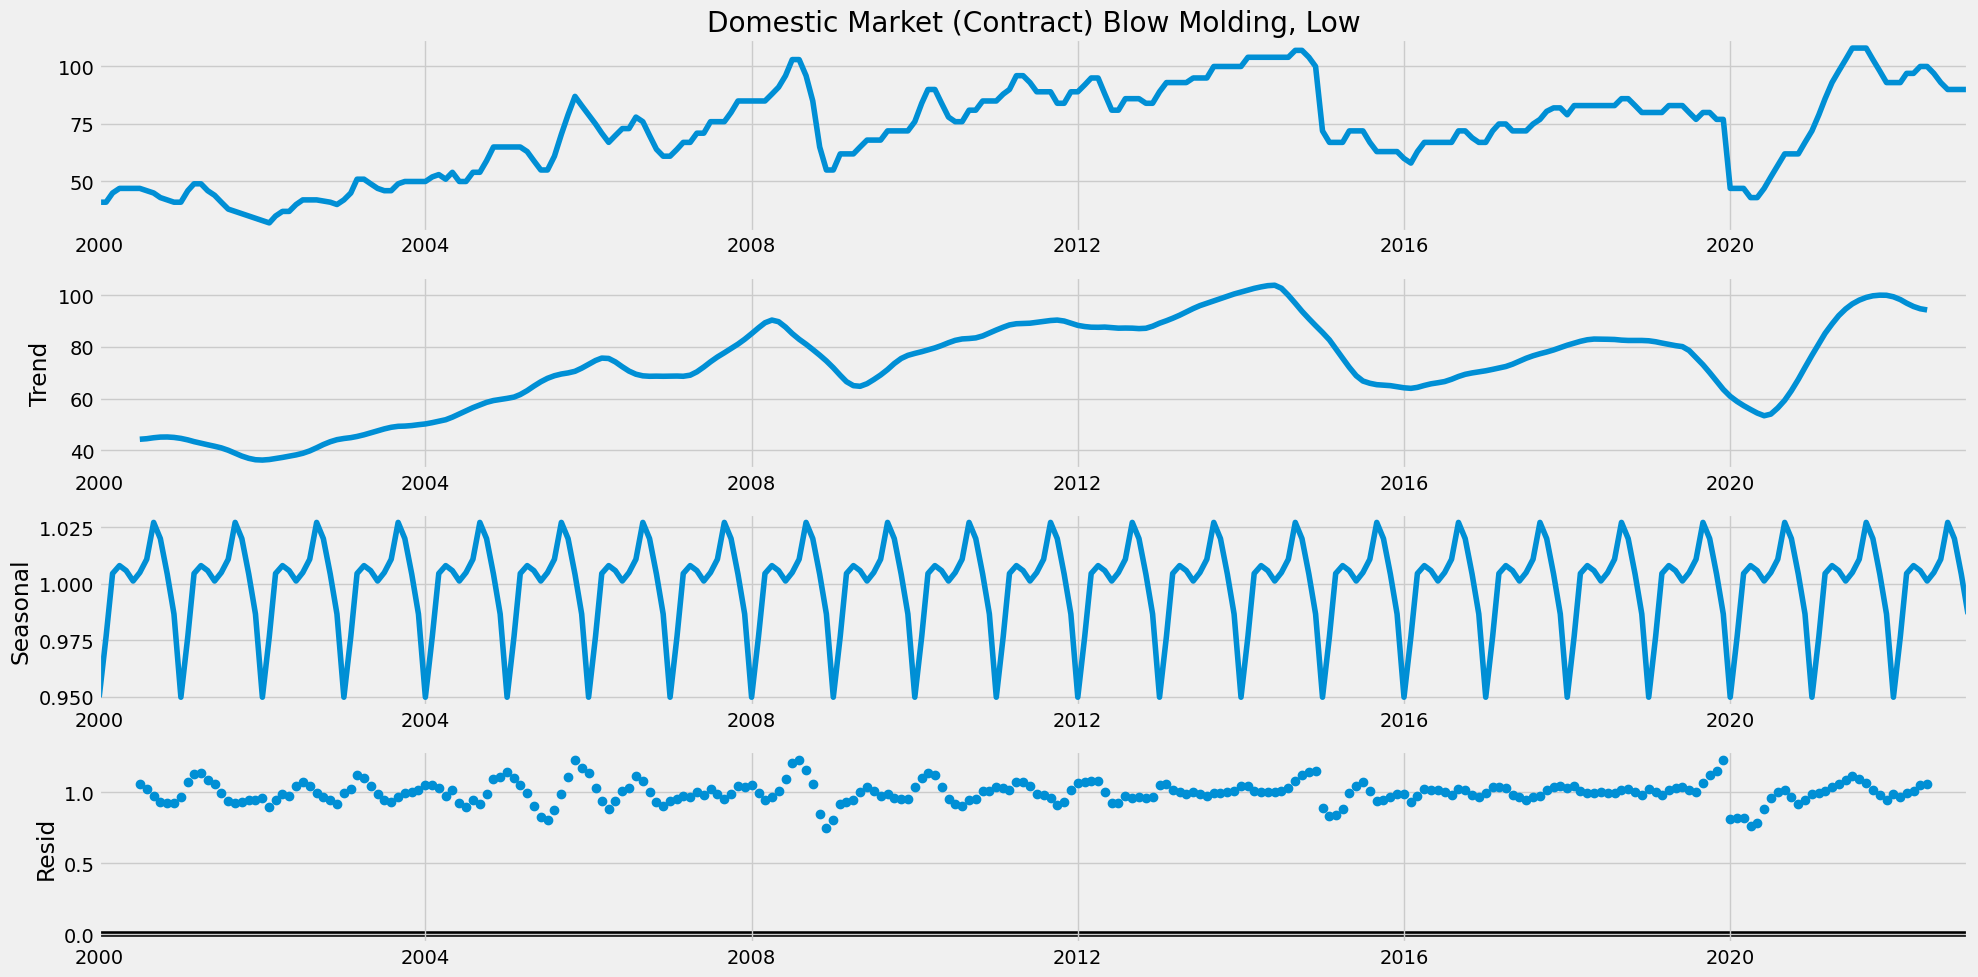

In [ ]:
decomposition = seasonal_decompose(df_univariate["Domestic Market (Contract) Blow Molding, Low"], period = 12, model = 'multiplicative')
figure = decomposition.plot()
plt.show()

In [ ]:
result = adfuller(decomposition.seasonal)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -576217591413796.000000
p-value: 0.000000


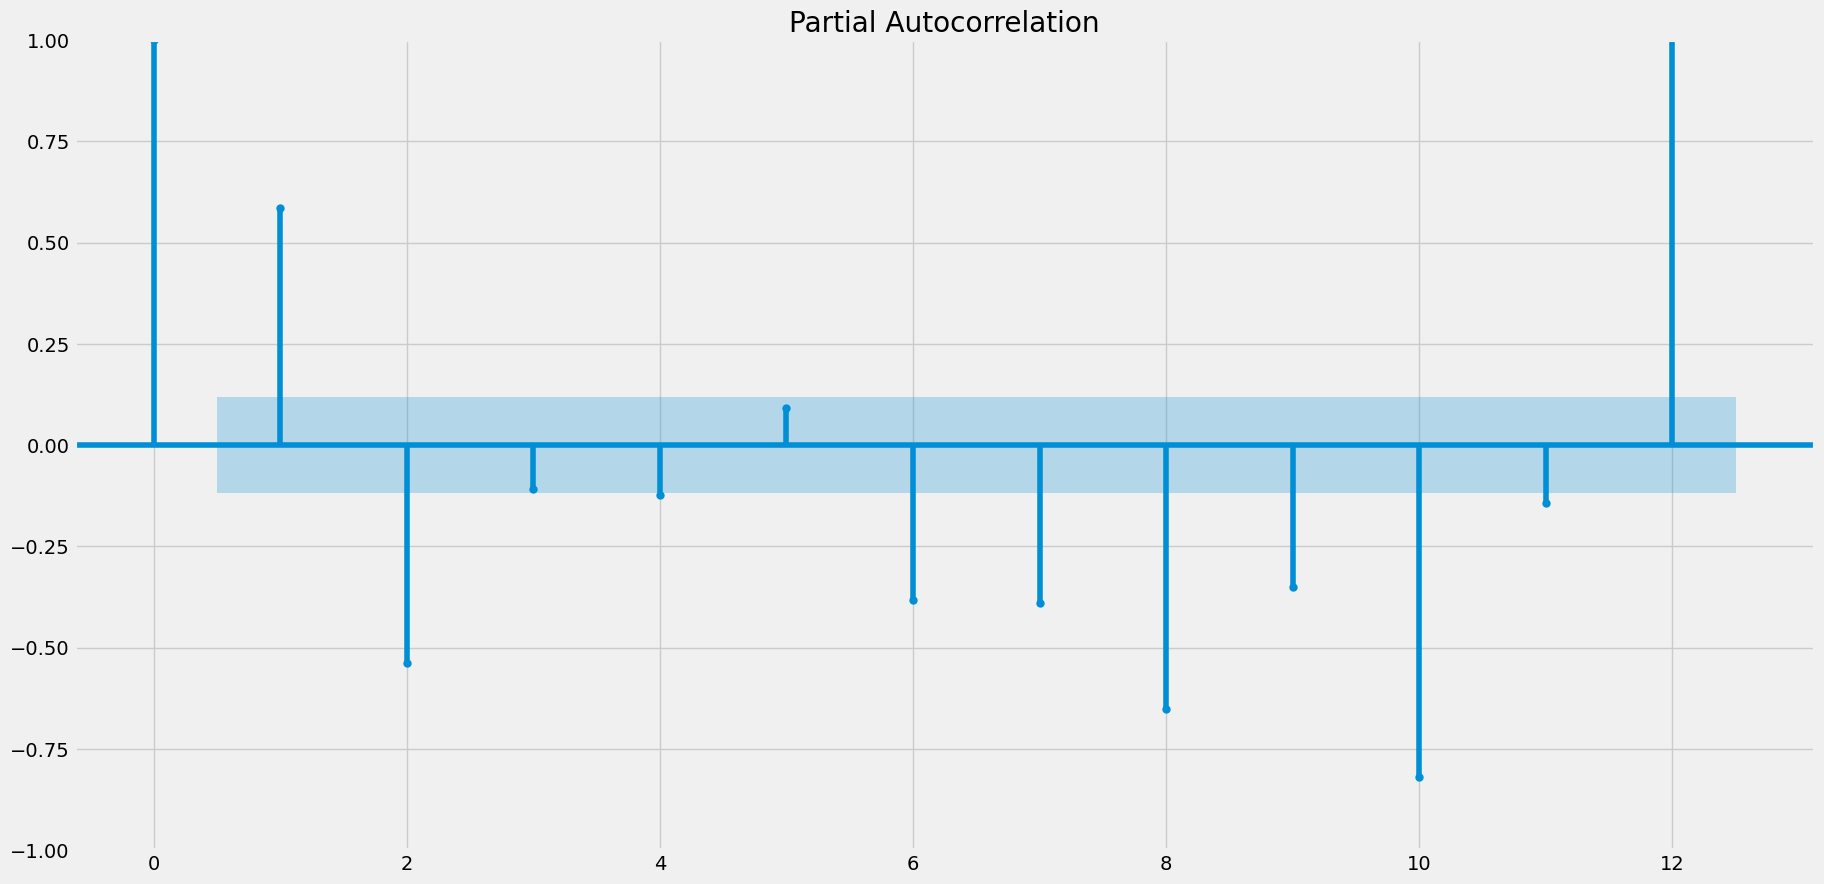

In [ ]:
plot_pacf(decomposition.seasonal, lags = 12); print()

Relevant PACF values up until lag 12 at least indicate  P
  = 1 is the right choice.

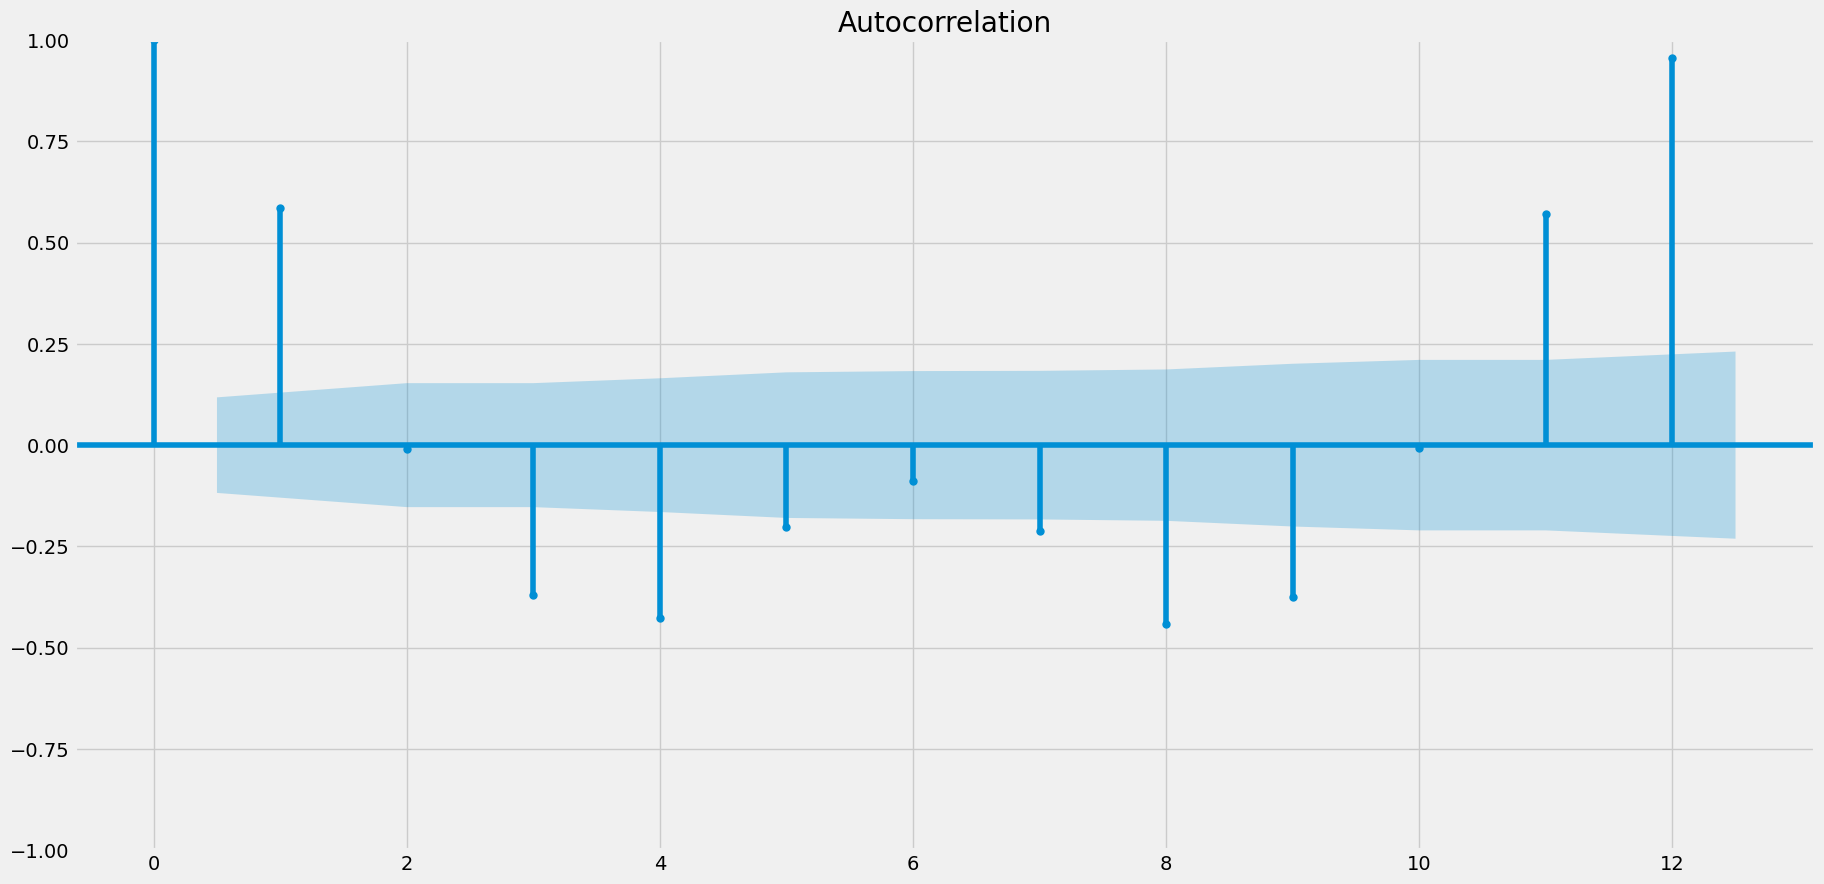

In [ ]:
plot_acf(decomposition.seasonal, lags = 12); print()

In [ ]:
xtrain.set_index("ds",inplace=True)

In [ ]:
#using auto arima for automatic p,d,q values
model_autoARIMA = auto_arima(xtrain, start_p=7, start_q=7 ,
                      test='adf',       
                      max_p= 7, max_q=7, 
                      m= 7,              
                      d= 1,
                      seasonal=True,   
                      start_P=1, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(6,1,6)(1,1,1)[7]             : AIC=inf, Time=9.36 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1333.865, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1240.851, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.01 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=1280.307, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=1212.203, Time=0.51 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=2.13 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.42 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=1262.414, Time=0.37 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=1208.074, Time=0.78 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=1238.822, Time=0.73 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=3.32 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=3.00 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=1206.085, Time=0.74 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=1236.856, Time=0.40 s

In [ ]:
forecast = model_autoARIMA.predict(n_periods=56)

In [ ]:
forecast

2018-05-01     84.630091
2018-06-01     86.386344
2018-07-01     85.692617
2018-08-01     83.816545
2018-09-01     85.003522
2018-10-01     85.927831
2018-11-01     88.281694
2018-12-01     90.767734
2019-01-01     91.708763
2019-02-01     90.246168
2019-03-01     88.760679
2019-04-01     90.181284
2019-05-01     91.682685
2019-06-01     93.387026
2019-07-01     96.061482
2019-08-01     97.399476
2019-09-01     96.645007
2019-10-01     94.503007
2019-11-01     96.807961
2019-12-01     97.621792
2020-01-01     98.854463
2020-02-01    101.104868
2020-03-01    102.505975
2020-04-01    101.609488
2020-05-01     99.718376
2020-06-01    101.405932
2020-07-01    102.420121
2020-08-01    104.173612
2020-09-01    106.609405
2020-10-01    107.827228
2020-11-01    106.756618
2020-12-01    104.955807
2021-01-01    106.689861
2021-02-01    107.835851
2021-03-01    109.449521
2021-04-01    111.929425
2021-05-01    113.234109
2021-06-01    112.320111
2021-07-01    110.373106
2021-08-01    112.305652


In [ ]:
np.array(xvalid["y"])

array([ 83.,  83.,  83.,  83.,  86.,  86.,  83.,  80.,  80.,  80.,  80.,
        83.,  83.,  83.,  80.,  77.,  80.,  80.,  77.,  77.,  47.,  47.,
        47.,  43.,  43.,  47.,  52.,  57.,  62.,  62.,  62.,  67.,  72.,
        79.,  86.,  93.,  98., 103., 108., 108., 108., 103.,  98.,  93.,
        93.,  93.,  97.,  97., 100., 100.,  97.,  93.,  90.,  90.,  90.,
        90.])

In [ ]:
metrics(np.array(xvalid["y"]),np.array(forecast))

Da: 0.2909090909090909
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
rmse: 28.89147429592397
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
mae: 23.449702788833015
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
mape: 0.3557370945169048
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
R2: -1.7954769264360628


In [ ]:
overall_predictions["sarima_pred"]=np.array(forecast)

In [ ]:
print(model_autoARIMA.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  220
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 7)   Log Likelihood                -594.247
Date:                           Mon, 29 May 2023   AIC                           1202.494
Time:                                   06:27:48   BIC                           1225.991
Sample:                               01-01-2000   HQIC                          1211.991
                                    - 04-01-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5022      0.056      8.932      0.000       0.392       0.612
ar.L2         -0.1129      0.093     -1.211

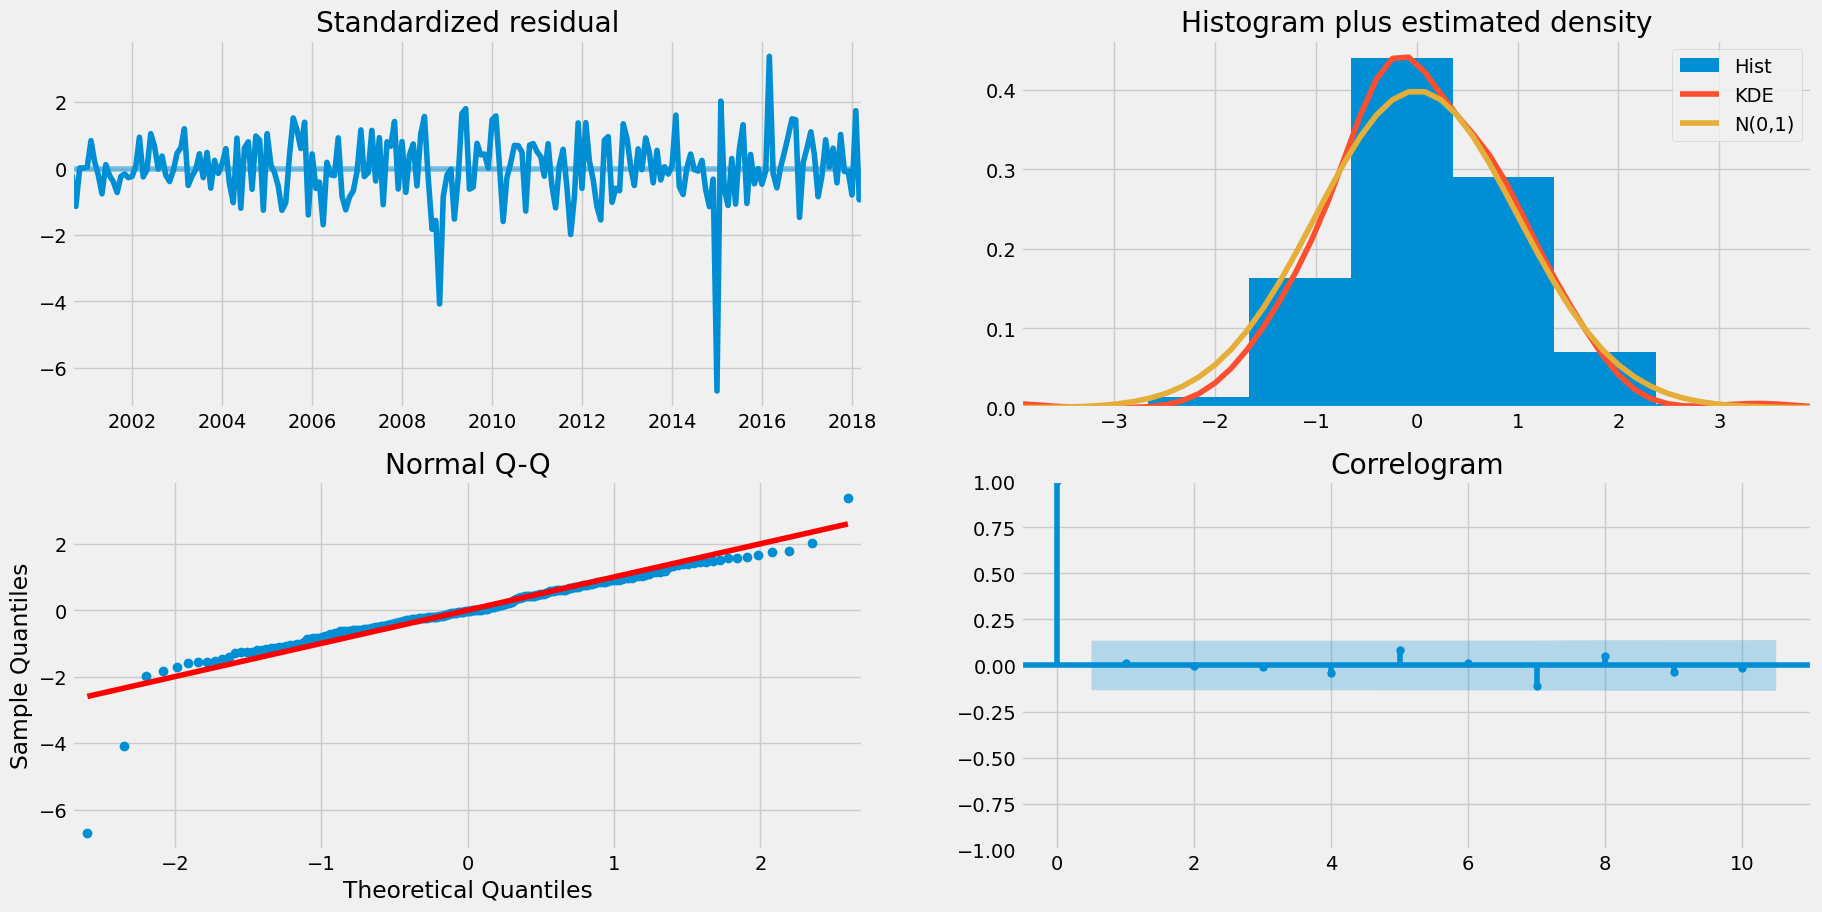

In [ ]:
model_autoARIMA.plot_diagnostics()
plt.show()

## Missing value imputation

In [33]:
df

,Date,"Domestic Market (Contract) Blow Molding, Low",Spot/Export Blow Molding,"Spot, Domestic",WTISPLC,MCOILBRENTEU,GASREGM,IMPCH,EXPCH,PRUBBUSDM,...,Russia_import,South_Africa_import,Turkey_import,Brazil_import,France_import,Germeny_import,United Kingdome_import,China_import,Japan_import,South_korea_import
0,2000-01-01,41.0,NaN,NaN,27.18,25.51,1.289,6902.100000,863.100000,29.207387,...,NaN,NaN,6833222.0,2649293.0,35239920.0,NaN,NaN,NaN,NaN,NaN
1,2000-02-01,41.0,NaN,NaN,29.35,27.78,1.377,6584.400000,972.700000,33.391099,...,NaN,NaN,5647987.0,2787667.0,36716752.0,NaN,NaN,NaN,NaN,NaN
2,2000-03-01,45.0,NaN,NaN,29.89,27.49,1.516,6424.100000,1330.500000,30.941913,...,NaN,NaN,6721125.0,4692701.0,45144561.0,NaN,NaN,NaN,NaN,NaN
3,2000-04-01,47.0,NaN,NaN,25.74,22.76,1.465,7070.500000,1227.500000,31.930148,...,NaN,NaN,7169182.0,2565068.0,32240349.0,NaN,NaN,NaN,NaN,NaN
4,2000-05-01,47.0,NaN,NaN,28.78,27.74,1.487,7850.200000,1526.300000,31.201702,...,NaN,NaN,10466333.0,4671325.0,29351633.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2022-08-01,93.0,NaN,NaN,93.67,100.45,3.975,50348.836582,12906.699996,73.304558,...,NaN,19310108.0,NaN,NaN,NaN,144131334.0,81872550.0,NaN,26097012.0,NaN
272,2022-09-01,90.0,NaN,NaN,84.26,89.76,3.700,49247.891499,11953.510580,66.956499,...,NaN,14410445.0,NaN,NaN,NaN,113310929.0,74477441.0,NaN,21277339.0,NaN
273,2022-10-01,90.0,NaN,NaN,87.55,93.33,3.815,44571.967124,15698.339652,68.535729,...,NaN,16783023.0,NaN,NaN,NaN,119307001.0,109421098.0,NaN,NaN,NaN
274,2022-11-01,90.0,NaN,NaN,84.37,91.42,3.685,36876.437049,15576.005996,65.265834,...,NaN,11079039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
from fancyimpute import IterativeImputer

In [35]:
miss=pd.DataFrame(df.isnull().sum()/(df.shape[0])*100)
del_col=miss[miss.values>80].index
miss_col=miss[(miss.values>0) & (miss.values<=80)].index

In [36]:
df=df.drop(del_col,axis=1)

In [37]:
df

,Date,"Domestic Market (Contract) Blow Molding, Low",Spot/Export Blow Molding,"Spot, Domestic",WTISPLC,MCOILBRENTEU,GASREGM,IMPCH,EXPCH,PRUBBUSDM,...,India_import,Russia_import,South_Africa_import,Turkey_import,Brazil_import,France_import,Germeny_import,United Kingdome_import,China_import,Japan_import
0,2000-01-01,41.0,NaN,NaN,27.18,25.51,1.289,6902.100000,863.100000,29.207387,...,NaN,NaN,NaN,6833222.0,2649293.0,35239920.0,NaN,NaN,NaN,NaN
1,2000-02-01,41.0,NaN,NaN,29.35,27.78,1.377,6584.400000,972.700000,33.391099,...,NaN,NaN,NaN,5647987.0,2787667.0,36716752.0,NaN,NaN,NaN,NaN
2,2000-03-01,45.0,NaN,NaN,29.89,27.49,1.516,6424.100000,1330.500000,30.941913,...,NaN,NaN,NaN,6721125.0,4692701.0,45144561.0,NaN,NaN,NaN,NaN
3,2000-04-01,47.0,NaN,NaN,25.74,22.76,1.465,7070.500000,1227.500000,31.930148,...,NaN,NaN,NaN,7169182.0,2565068.0,32240349.0,NaN,NaN,NaN,NaN
4,2000-05-01,47.0,NaN,NaN,28.78,27.74,1.487,7850.200000,1526.300000,31.201702,...,NaN,NaN,NaN,10466333.0,4671325.0,29351633.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2022-08-01,93.0,NaN,NaN,93.67,100.45,3.975,50348.836582,12906.699996,73.304558,...,120324617.0,NaN,19310108.0,NaN,NaN,NaN,144131334.0,81872550.0,NaN,26097012.0
272,2022-09-01,90.0,NaN,NaN,84.26,89.76,3.700,49247.891499,11953.510580,66.956499,...,156434480.0,NaN,14410445.0,NaN,NaN,NaN,113310929.0,74477441.0,NaN,21277339.0
273,2022-10-01,90.0,NaN,NaN,87.55,93.33,3.815,44571.967124,15698.339652,68.535729,...,155159512.0,NaN,16783023.0,NaN,NaN,NaN,119307001.0,109421098.0,NaN,NaN
274,2022-11-01,90.0,NaN,NaN,84.37,91.42,3.685,36876.437049,15576.005996,65.265834,...,NaN,NaN,11079039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df[miss_col]=df[miss_col].astype("float")

**Iterative** **Imputer**:
- Iterative imputation works by iteratively estimating missing values based on the observed values and updating the estimates in each iteration until convergence. The imputer models the relationships between features to impute missing values more accurately.

- Remember to preprocess your data, handle any necessary feature scaling, and address any other data preparation steps before applying iterative imputation. Additionally, keep in mind that iterative imputation assumes that the missing values are missing at random (MAR) and that the missingness pattern does not contain valuable information for prediction.

In [39]:
def train_imputation(df):
    # Create an instance of the IterativeImputer
    imputer = IterativeImputer()
    
    df[miss_col] = imputer.fit_transform(df[miss_col])
train_imputation(df)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


First, an instance of IterativeImputer is created. By default, it uses a linear regression model for imputation, but you can specify a different model by setting the estimator parameter with the desired model.

Next, the imputer is fitted on the dataset using the fit method, which learns the imputation model based on the available data. Finally, the transform method is used to perform the imputation, replacing the missing values in X with the imputed values and returning the resulting dataset as X_imputed.

In [40]:
df.set_index("Date",inplace=True)

## LSTM


Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture that is commonly used for time series analysis and forecasting. LSTM networks are designed to capture dependencies and patterns in sequential data by leveraging memory cells and gating mechanisms.

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
target=df["Domestic Market (Contract) Blow Molding, Low"]
features=df.drop("Domestic Market (Contract) Blow Molding, Low",axis=1)

x_train,x_test,y_train,y_test=train_test_split(features,target,test_size=0.20,shuffle=False)

print('x_train',x_train.shape)
print('x_test',x_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

x_train (220, 44)
x_test (56, 44)
y_train (220,)
y_test (56,)


In [42]:
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf

In [43]:
trainX = np.reshape(np.array(x_train), (x_train.shape[0], 1, x_train.shape[1]))
testX = np.reshape(np.array(x_test), (x_test.shape[0], 1, x_test.shape[1]))

In [44]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [46]:
#model architecture
model=tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(6,input_shape=(1,44),return_sequences=True)) 
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(6,return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(3))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [47]:
early_stoping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min')

#Commpiling the model
model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(),metrics=[tf.metrics.MeanSquaredError()])

#Fitting the Model and creating a object names 'history' which holds all the params learnt while training


In [48]:
history=model.fit(trainX, y_train, epochs=10,shuffle=False)

Epoch 1/10
7/7 [==============================] - 13s 6ms/step - loss: 5295.1738 - mean_squared_error: 5295.1738
Epoch 2/10
7/7 [==============================] - 0s 5ms/step - loss: 5292.9897 - mean_squared_error: 5292.9897
Epoch 3/10
7/7 [==============================] - 0s 5ms/step - loss: 5290.5356 - mean_squared_error: 5290.5356
Epoch 4/10
7/7 [==============================] - 0s 4ms/step - loss: 5288.4688 - mean_squared_error: 5288.4688
Epoch 5/10
7/7 [==============================] - 0s 5ms/step - loss: 5286.4712 - mean_squared_error: 5286.4712
Epoch 6/10
7/7 [==============================] - 0s 6ms/step - loss: 5284.5059 - mean_squared_error: 5284.5059
Epoch 7/10
7/7 [==============================] - 0s 6ms/step - loss: 5282.4546 - mean_squared_error: 5282.4546
Epoch 8/10
7/7 [==============================] - 0s 5ms/step - loss: 5279.9922 - mean_squared_error: 5279.9922
Epoch 9/10
7/7 [==============================] - 0s 5ms/step - loss: 5278.0718 - mean_squared_error: 5

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 6)              1224      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1, 6)              0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 6)              312       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1, 6)              0         
                                                                 
 dropout_2 (Dropout)         (None, 1, 6)              0         
                                                                 
 lstm_5 (LSTM)               (None, 3)                 120       
                                                                 
 dropout_3 (Dropout)         (None, 3)                

In [50]:
predictions=model.predict(testX)

2/2 [==============================] - 1s 5ms/step


In [51]:
metrics(y_test,predictions)

Da: 0.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
rmse: 82.80887576417246
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
mae: 80.98577168823353
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
mape: 0.9984098238465661
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
R2: -21.96520260990308


<ipython-input-3-60b5397d4e95>:22: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  num_correct = np.sum(actual_signs == predicted_signs)


In [52]:
overall_predictions["LSTM_pred"]=predictions

## Lazy predict model

In [57]:
pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
from lazypredict.Supervised import LazyRegressor

In [62]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(x_train, x_test, y_train, y_test)

100%|██████████| 42/42 [00:06<00:00,  6.27it/s]


In [63]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LinearSVR,-0.26,0.75,8.66,0.02
ExtraTreesRegressor,-0.36,0.73,9.03,0.26
KNeighborsRegressor,-0.44,0.71,9.29,0.08
LassoLars,-0.58,0.68,9.71,0.02
Lasso,-0.58,0.68,9.72,0.03
GradientBoostingRegressor,-0.63,0.67,9.88,0.35
RandomForestRegressor,-0.71,0.66,10.11,0.49
XGBRegressor,-0.73,0.65,10.16,0.29
AdaBoostRegressor,-0.77,0.65,10.28,0.96


## Time Series Cross Validation

In [64]:
from sklearn.model_selection import TimeSeriesSplit
'''parameters
 n_splits: number of splits for given data
 test_size: predict the last 20 % of data i.e 56 data points 
 gap: gap between train and test data 
 '''

tss = TimeSeriesSplit(n_splits=5, test_size=24)

df = df.sort_index()

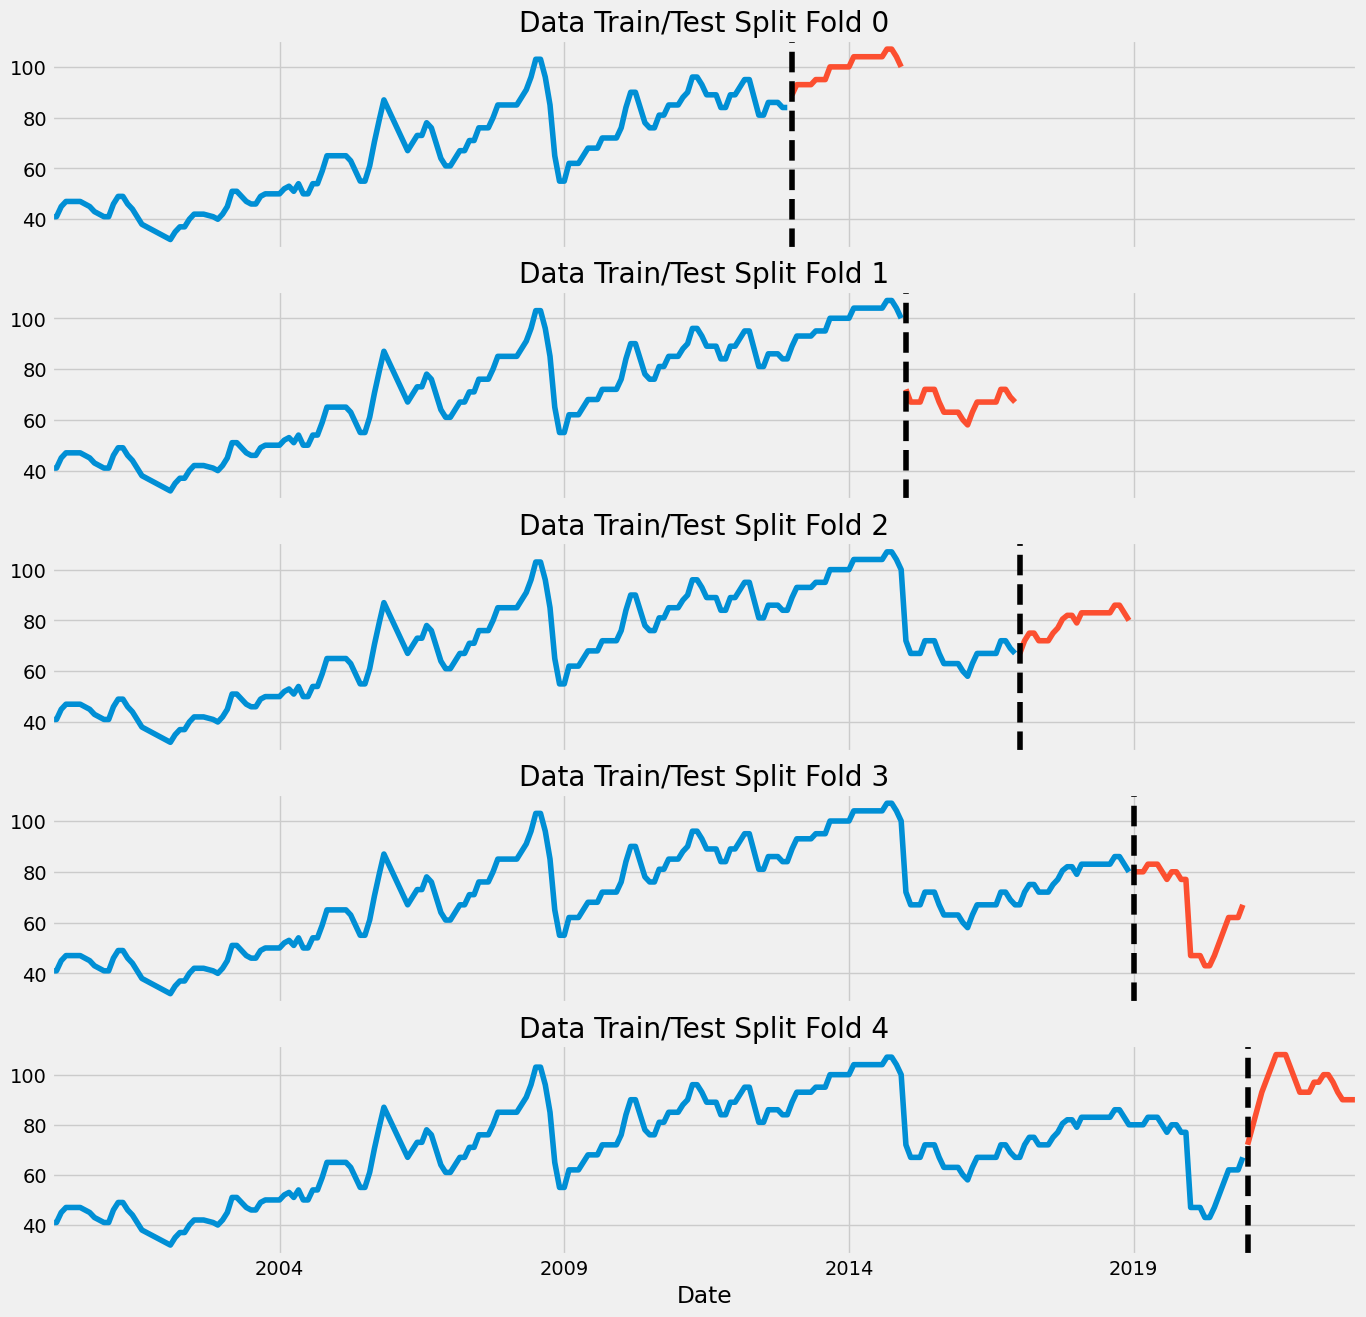

In [66]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):  # Iterate over the train/validation splits
    train = df.iloc[train_idx]  # Get the training data for this fold
    test = df.iloc[val_idx]  # Get the validation data for this fold
    
    # Plot the training data
    train['Domestic Market (Contract) Blow Molding, Low'].plot(ax=axs[fold],
                                                              label='Training Set',
                                                              title=f'Data Train/Test Split Fold {fold}')
    
    # Plot the validation data
    test['Domestic Market (Contract) Blow Molding, Low'].plot(ax=axs[fold],
                                                             label='Test Set')
    
    axs[fold].axvline(test.index.min(), color='black', ls='--')  # Add a vertical line to indicate the split point
    
    fold += 1  # Increment the fold counter

plt.show()  # Display the plots


## Create a new features and lag features

In [71]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

df = create_features(df)

In [67]:
def add_lags(df):
    # Add lagged features to the DataFrame
    df['lag1'] = df['Domestic Market (Contract) Blow Molding, Low'].shift(1)  # Add lag 1 feature
    df['lag2'] = df['Domestic Market (Contract) Blow Molding, Low'].shift(2)  # Add lag 2 feature
    df['lag3'] = df['Domestic Market (Contract) Blow Molding, Low'].shift(3)  # Add lag 3 feature
    return df  # Return the modified DataFrame


In [68]:
df=add_lags(df)

In [69]:
import xgboost as xgb

In [72]:
tss = TimeSeriesSplit(n_splits=4, test_size=56, gap=0)  # Time series cross-validation with 4 splits, test size of 56, and no gap
df = df.sort_index()  # Sorting the DataFrame by index

fold = 0  # Counter for the fold number
preds = []  # List to store the predictions
scores = []  # List to store the scores

for train_idx, val_idx in tss.split(df):  # Iterate over the train/validation splits
    train = df.iloc[train_idx]  # Get the training data for this fold
    test = df.iloc[val_idx]  # Get the validation data for this fold

    train = create_features(train)  # Creating additional features for the training data
    test = create_features(test)  # Creating additional features for the validation data

    FEATURES = df.drop("Domestic Market (Contract) Blow Molding, Low", axis=1).columns  # Selecting features for the model
    TARGET = 'Domestic Market (Contract) Blow Molding, Low'  # Target variable

    X_train = train[FEATURES]  # Features for training data
    y_train = train[TARGET]  # Target variable for training data

    X_test = test[FEATURES]  # Features for validation data
    y_test = test[TARGET]  # Target variable for validation data

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000,
                           early_stopping_rounds=50, objective='reg:linear',
                           max_depth=3, learning_rate=0.01)  # XGBoost regressor model with specified parameters
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)  # Fitting the model

    y_pred = reg.predict(X_test)  # Making predictions on the validation data
    preds.append(y_pred)  # Storing the predictions
    score = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculating the root mean squared error
    scores.append(score)  # Storing the score



[14:06:10] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:43.11092	validation_1-rmse:72.24140
[100]	validation_0-rmse:16.50429	validation_1-rmse:44.43033
[200]	validation_0-rmse:6.45400	validation_1-rmse:33.15193
[300]	validation_0-rmse:2.61924	validation_1-rmse:28.51656
[400]	validation_0-rmse:1.12599	validation_1-rmse:26.73495
[500]	validation_0-rmse:0.54017	validation_1-rmse:25.93915
[600]	validation_0-rmse:0.30828	validation_1-rmse:25.43454
[700]	validation_0-rmse:0.19401	validation_1-rmse:25.21177
[800]	validation_0-rmse:0.13120	validation_1-rmse:25.10054
[900]	validation_0-rmse:0.09478	validation_1-rmse:25.05796
[999]	validation_0-rmse:0.06867	validation_1-rmse:25.03223
[14:06:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:59.83406	validation_1-rmse:82.44108
[100]	validation_0-rmse:23.07878	validation_1-rmse:34.1

In [73]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 11.0998
Fold scores:[25.032233853910668, 4.296087502803843, 9.110722243368853, 5.960240920373554]


In [74]:
metrics(y_test.to_numpy(),y_pred)

Da: 0.43636363636363634
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
rmse: 5.960240920373554
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
mae: 4.356882640293667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
mape: 0.06481390977815538
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
R2: 0.8810281722098172


In [75]:
overall_predictions["xgb_pred"]=y_pred

# Feature Importance

<Figure size 1200x800 with 0 Axes>

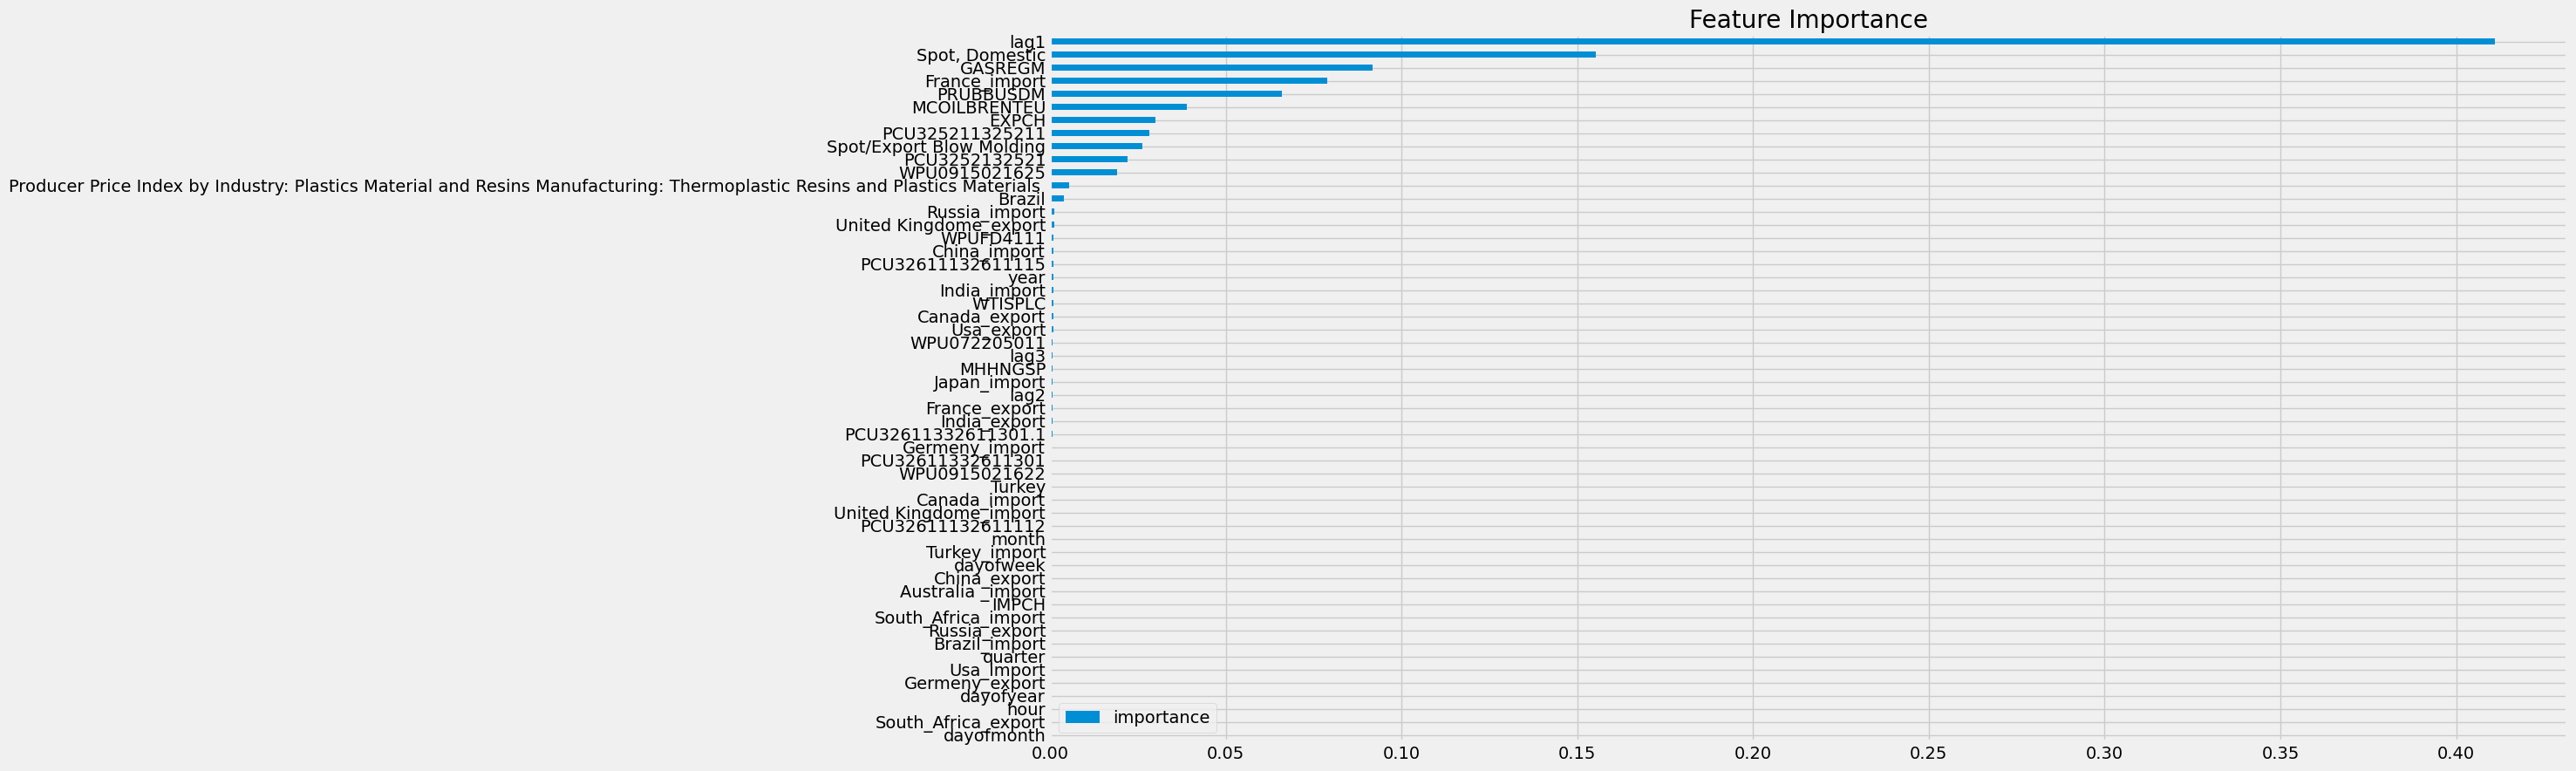

In [76]:
plt.figure(figsize=(12,8))
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [79]:
fi.sort_values('importance',ascending=False)[0:8]


,importance
lag1,0.41
"Spot, Domestic",0.16
GASREGM,0.09
France_import,0.08
PRUBBUSDM,0.07
MCOILBRENTEU,0.04
EXPCH,0.03
PCU325211325211,0.03


# Overall predictions

In [96]:
overall_predictions["date"]=df.index[-56:]
overall_predictions.set_index("date",inplace=True)

**M+1 Month Results**

In [97]:
results={}
col=overall_predictions.columns
for i in col:
  results[i]=[mda(overall_predictions["ytrue"],overall_predictions[i]),
              np.sqrt(mean_squared_error(overall_predictions["ytrue"],overall_predictions[i])),
              mean_absolute_error(overall_predictions["ytrue"],overall_predictions[i]),
              mean_absolute_percentage_error(overall_predictions["ytrue"],overall_predictions[i]),
              r2_score(overall_predictions["ytrue"],overall_predictions[i])]

In [98]:
m1_results=pd.DataFrame(results,index=["Directional_acc","RMSE","MAE","MAPE","R2"])
m1_results.T

,Directional_acc,RMSE,MAE,MAPE,R2
ytrue,1.00,0.00,0.00,0.00,1.00
exp_pred,0.31,18.35,14.31,0.20,-0.13
LSTM_pred,0.44,82.81,80.99,1.00,-21.97
xgb_pred,0.44,5.96,4.36,0.06,0.88
pro_pred,0.38,17.17,13.01,0.19,0.01


**M+2 Month Results**

In [99]:
m2=overall_predictions.iloc[::2]

In [100]:
m2_results={}
col=m2.columns
for i in col:
  m2_results[i]=[mda(m2["ytrue"],m2[i]),
              np.sqrt(mean_squared_error(m2["ytrue"],m2[i])),
              mean_absolute_error(m2["ytrue"],m2[i]),
              mean_absolute_percentage_error(m2["ytrue"],m2[i]),
              r2_score(m2["ytrue"],m2[i])]

In [106]:
m2_results=pd.DataFrame(m2_results,index=["DA","RMSE","MAE","MAPE","R2"])
m2_results.T

,DA,RMSE,MAE,MAPE,R2
ytrue,1.00,0.00,0.00,0.00,1.00
exp_pred,0.69,18.91,14.57,0.21,-0.07
LSTM_pred,0.38,82.29,80.24,1.00,-19.28
xgb_pred,0.92,8.02,5.25,0.09,0.81
pro_pred,0.69,17.91,13.47,0.21,0.04


**M+3 Month results**

In [103]:
m2=overall_predictions.iloc[::3]
m2_results={}
col=m2.columns
for i in col:
  m2_results[i]=[mda(m2["ytrue"],m2[i]),
              np.sqrt(mean_squared_error(m2["ytrue"],m2[i])),
              mean_absolute_error(m2["ytrue"],m2[i]),
              mean_absolute_percentage_error(m2["ytrue"],m2[i]),
              r2_score(m2["ytrue"],m2[i])]
m3_results=pd.DataFrame(m2_results,index=["Directional_acc","RMSE","MAE","MAPE","R2"])
m3_results.T

,Directional_acc,RMSE,MAE,MAPE,R2
ytrue,1.00,0.00,0.00,0.00,1.00
exp_pred,0.39,18.25,14.05,0.20,-0.12
LSTM_pred,0.39,82.43,80.62,1.00,-21.95
xgb_pred,0.78,5.53,4.37,0.06,0.90
pro_pred,0.67,17.07,12.73,0.19,0.02


**Quarterly Month results**

In [104]:
m2=overall_predictions.iloc[::4]
m2_results={}
col=m2.columns
for i in col:
  m2_results[i]=[mda(m2["ytrue"],m2[i]),
              np.sqrt(mean_squared_error(m2["ytrue"],m2[i])),
              mean_absolute_error(m2["ytrue"],m2[i]),
              mean_absolute_percentage_error(m2["ytrue"],m2[i]),
              r2_score(m2["ytrue"],m2[i])]
q_results=pd.DataFrame(m2_results,index=["Directional_acc","RMSE","MAE","MAPE","R2"])
q_results.T

,Directional_acc,RMSE,MAE,MAPE,R2
ytrue,1.00,0.00,0.00,0.00,1.00
exp_pred,0.69,18.91,14.57,0.21,-0.07
LSTM_pred,0.38,82.29,80.24,1.00,-19.28
xgb_pred,0.92,8.02,5.25,0.09,0.81
pro_pred,0.69,17.91,13.47,0.21,0.04
